### 0. Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
import os

plt.style.use('seaborn-v0_8-whitegrid')

### 1. Load Dataset & Define Columns
The C-MAPSS dataset is provided without headers. Based on the documentation, we manually define the column names for the index, operational settings, and 21 sensor measurements. We then load the training, testing, and ground truth (RUL) files using the relative paths established in our directory structure.

In [2]:
# dataset can be downloaded from dataset_download.ipynb
data_path = '../data/raw/nasa-cmaps/CMaps/'

# We define column names based on the dataset readme.md
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i}' for i in range(1, 22)] 
col_names = index_names + setting_names + sensor_names

# Reading train, test and RUL files
train_df = pd.read_csv(data_path + 'train_FD001.txt', sep='\s+', header=None, names=col_names)
test_df = pd.read_csv(data_path + 'test_FD001.txt', sep='\s+', header=None, names=col_names)
rul_df = pd.read_csv(data_path + 'RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")
print(f"True RUL Shape: {rul_df.shape}")

train_df.head()

Train Shape: (20631, 26)
Test Shape: (13096, 26)
True RUL Shape: (100, 1)


,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### 2. Feature Engineering: Remaining Useful Life (RUL)
For the training set, which follows a "run-to-failure" trajectory, the RUL at any time step is calculated as the difference between the maximum cycle of that engine and the current cycle. For the test set, the data is truncated prior to failure. We calculate the RUL by adding the provided "True RUL" values (from RUL_FD001.txt) to the last observed cycle of each engine in the test set.

In [3]:
# TRAIN SET RUL

# Calculate max life for each engine in the training set
# Merge max_life back to the dataframe
max_cycle_train = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycle_train.columns = ['unit_number', 'max_life']
train_df = train_df.merge(max_cycle_train, on='unit_number', how='left')

# Calculate RUL: Max Life - Current Cycle
# Drop the helper column
train_df['RUL'] = train_df['max_life'] - train_df['time_cycles']
train_df.drop(columns=['max_life'], inplace=True)

In [4]:
# TEST SET RUL 

# Get the last cycle for each engine in the test set
max_cycle_test = test_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycle_test.columns = ['unit_number', 'max_cycle']

# Align unit numbers in the RUL dataframe
rul_df['unit_number'] = rul_df.index + 1 

# Merge Max Cycle and True RUL into test dataframe
test_df = test_df.merge(max_cycle_test, on='unit_number', how='left')
test_df = test_df.merge(rul_df, on='unit_number', how='left')

# Calculate RUL for test set: 
# (True RUL at the end of the sequence) + (Last Cycle - Current Cycle)
test_df['RUL'] = test_df['RUL'] + test_df['max_cycle'] - test_df['time_cycles']
test_df.drop(columns=['max_cycle'], inplace=True)
train_df[['unit_number', 'time_cycles', 'RUL']].head()

,unit_number,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


### 3. Data Cleaning: Drop Constant Sensors, Missing Value Check
The FD001 dataset represents a single operating condition (Sea Level) and a single fault mode (HPC Degradation). Consequently, several sensors exhibit zero variance. These constant features contain no information and are removed to reduce noise and computational cost. Missing value checks were performed prior to data splitting and normalization to ensure numerical stability and to prevent error propagation during scaling and model training.

In [5]:
# Identify columns with 0 standard deviation (constant values) in the training set
const_cols = [col for col in train_df.columns if train_df[col].std() < 1e-5]
print(f"Dropping constant columns: {const_cols}")

# Drop these columns from both Train and Test datasets
train_df.drop(columns=const_cols, inplace=True)
test_df.drop(columns=const_cols, inplace=True)

# Define the list of useful input features (remaining sensors)
features = [col for col in sensor_names if col not in const_cols]
print(f"Selected features ({len(features)}): {features}")

print(f"NaNs in Train DF: {train_df.isnull().sum().sum()}")
print(f"NaNs in Test DF:  {test_df.isnull().sum().sum()}")

# FD001 raw data has no NaNs, but this ensures robustness
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

Dropping constant columns: ['setting_3', 's_1', 's_5', 's_10', 's_16', 's_18', 's_19']
Selected features (15): ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
NaNs in Train DF: 0
NaNs in Test DF:  0


### 4. Splitting & Scaling
To evaluate our models correctly, we must prevent data leakage. Since our data consists of time series from distinct engines, we perform a Grouped Split based on unit_number rather than a random shuffle. We split the training data into 80% Train and 20% Validation. Finally, we normalize the sensor data using StandardScaler to ensure all features contribute equally to the model loss.

In [6]:
# Split Train into Train (80%) and Validation (20%) based on Unit Numbers
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
train_idx, val_idx = next(gss.split(train_df, groups=train_df['unit_number']))
X_train = train_df.iloc[train_idx].copy()
X_val = train_df.iloc[val_idx].copy()

print(f"Unique Engines in Train: {X_train['unit_number'].nunique()}")
print(f"Unique Engines in Val:   {X_val['unit_number'].nunique()}")

# Initialize Scaler
# Fit scaler ONLY on the Training data to avoid look-ahead bias
# Apply the same transformation to Validation and Test sets
scaler = StandardScaler()
X_train[features] = scaler.fit_transform(X_train[features])
X_val[features] = scaler.transform(X_val[features])
test_df[features] = scaler.transform(test_df[features])

Unique Engines in Train: 80
Unique Engines in Val:   20


### 6. Feature Engineering: Smoothing (Rolling Mean)
According to the reference paper, the sensor data is contaminated with noise. To reveal the underlying degradation trend and improve model performance, we apply a Rolling Mean (Moving Average). We apply this grouped by unit_number to ensure the smoothing does not cross between different engines. Function below applies rolling mean and standard deviation to sensor features. Group by 'unit_number' so we don't mix data from different engines.

New Feature Count (Train): 50


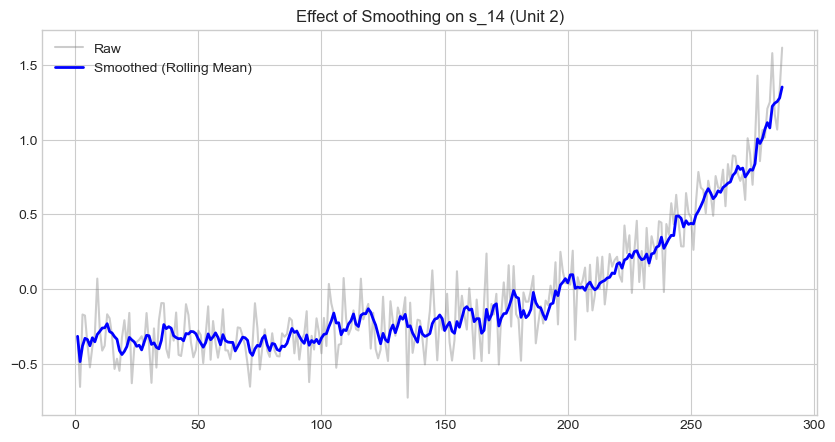

In [7]:
def apply_rolling_features(df, features, window_size=5):

    # Create a copy to avoid SettingWithCopy warning
    # Apply rolling only on feature columns
    df_rolled = df.copy()
    rolled = df_rolled.groupby('unit_number')[features].rolling(window=window_size, min_periods=1)
    
    # Calculate Mean and Std
    # Fill initial NaNs in std columns (std requires at least 2 points) with 0
    df_rolled[[f'{col}_mean' for col in features]] = rolled.mean().reset_index(level=0, drop=True)
    df_rolled[[f'{col}_std' for col in features]] = rolled.std().reset_index(level=0, drop=True)
    df_rolled.fillna(0, inplace=True)
    
    return df_rolled

# Apply to X_train, X_val, and test_df
window = 5
X_train_eng = apply_rolling_features(X_train, features, window_size=window)
X_val_eng   = apply_rolling_features(X_val, features, window_size=window)
test_df_eng = apply_rolling_features(test_df, features, window_size=window)
print(f"New Feature Count (Train): {X_train_eng.shape[1]}")

# Visualize Raw vs Smooth
sensor = 's_14' # for example
unit_id = X_train['unit_number'].iloc[0]

plt.figure(figsize=(10, 5))
subset = X_train[X_train['unit_number'] == unit_id] 
plt.plot(subset['time_cycles'], subset[sensor], label='Raw', alpha=0.4, color='gray')
subset_eng = X_train_eng[X_train_eng['unit_number'] == unit_id]
plt.plot(subset_eng['time_cycles'], subset_eng[f'{sensor}_mean'], label='Smoothed (Rolling Mean)', color='blue', linewidth=2)
plt.title(f"Effect of Smoothing on {sensor} (Unit {unit_id})")
plt.legend()
plt.show()

### 7. Feature Engineering: PCA Analysis
we perform PCA to understand the dimensionality of the data. FD001 has 14 active sensors (after dropping constants), but many are highly correlated. PCA helps us visualize how many components are needed to explain the variance, which is useful for reducing input size for RL agents later.

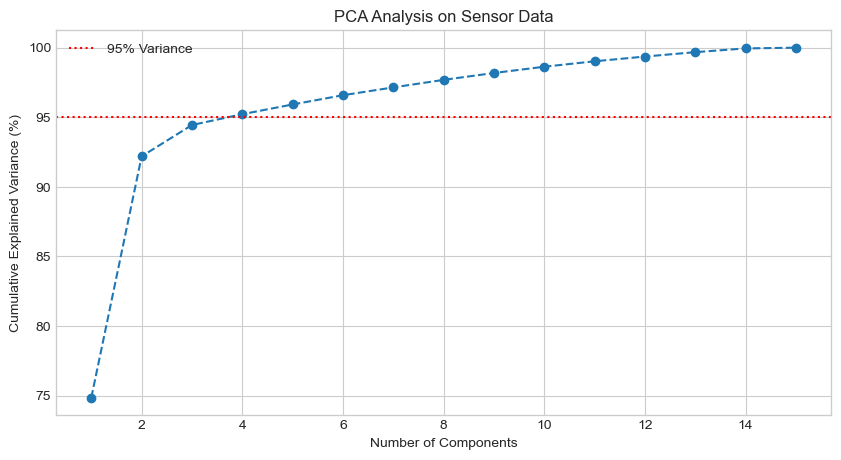

Number of components to explain 95% variance: 4


In [8]:
# Use the smoothed mean features for PCA then fit PCA on Training Data
smooth_features = [f'{col}_mean' for col in features]
pca = PCA(n_components=len(smooth_features))
pca.fit(X_train_eng[smooth_features])
cum_var = np.cumsum(pca.explained_variance_ratio_) * 100

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(smooth_features) + 1), cum_var, marker='o', linestyle='--')
plt.axhline(y=95, color='r', linestyle=':', label='95% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA Analysis on Sensor Data')
plt.grid(True)
plt.legend()
plt.show()

# determine number of components for 95% variance
n_components_95 = np.argmax(cum_var >= 95) + 1
print(f"Number of components to explain 95% variance: {n_components_95}")

### 8. Advanced Feature Engineering: Interaction Features
We generate interaction terms using polynomial expansion to capture non-linear physical relationships (e.g., pressure ratios, efficiency curves) that raw linear sensors cannot express directly. To avoid the curse of dimensionality, we first identify the top sensors most correlated with RUL. We then generate quadratic interactions specifically for these sensors and retain only the new features that demonstrate a stronger correlation with the target variable than the original raw data.

In [9]:
# Calculate correlation matrix
# Select top 6 sensors with highest absolute correlation to RUL 
corr_matrix = X_train_eng.corr()
top_sensors = corr_matrix['RUL'].abs().sort_values(ascending=False).head(7).index.tolist()
if 'RUL' in top_sensors: top_sensors.remove('RUL')
print(f"Generating interactions for: {top_sensors}")

# Generate polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly_train = poly.fit_transform(X_train_eng[top_sensors])
poly_cols = poly.get_feature_names_out(top_sensors)

# Create temporary DataFrame for analysis
df_poly = pd.DataFrame(X_poly_train, columns=poly_cols, index=X_train_eng.index)
df_poly['RUL'] = X_train_eng['RUL']

# Select Best New Features based on Correlation
print("\nTop Interaction Features by Correlation with RUL:")
poly_corr = df_poly.corr()['RUL'].abs().sort_values(ascending=False)
print(poly_corr.head(10))

# Select top 5 features that are NOT in the original dataset
new_feats = [col for col in poly_corr.index if col not in X_train_eng.columns and col != 'RUL'][:5]
print(f"\nSelected new features: {new_feats}")

# Transform 
X_train_eng[new_feats] = df_poly[new_feats]
X_poly_val = poly.transform(X_val_eng[top_sensors])
df_poly_val = pd.DataFrame(X_poly_val, columns=poly_cols, index=X_val_eng.index)
X_val_eng[new_feats] = df_poly_val[new_feats]
X_poly_test = poly.transform(test_df_eng[top_sensors])
df_poly_test = pd.DataFrame(X_poly_test, columns=poly_cols, index=test_df_eng.index)
test_df_eng[new_feats] = df_poly_test[new_feats]

# Final Feature Set
features_eng = features + new_feats
print(f"Total Features: {len(features_eng)}")

Generating interactions for: ['time_cycles', 's_11_mean', 's_4_mean', 's_21_mean', 's_15_mean', 's_20_mean']

Top Interaction Features by Correlation with RUL:
RUL                      1.000000
time_cycles              0.722221
s_11_mean                0.719720
s_4_mean                 0.719454
s_21_mean                0.712556
s_15_mean                0.710103
s_20_mean                0.704549
time_cycles s_11_mean    0.613637
time_cycles^2            0.611998
time_cycles s_4_mean     0.609602
Name: RUL, dtype: float64

Selected new features: ['time_cycles s_11_mean', 'time_cycles^2', 'time_cycles s_4_mean', 'time_cycles s_21_mean', 'time_cycles s_15_mean']
Total Features: 20


### 9. Save Processed Data
We save the final engineered dataframes to CSV files for use in the Baseline and LSTM/RL modeling stages. This ensures consistency and prevents re-running preprocessing steps.

In [10]:
# Define processed data directory
processed_dir = '../data/processed'
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

# Add RUL column back to X_train/X_val for saving
if 'RUL' not in X_train_eng.columns:
    X_train_eng['RUL'] = X_train['RUL']
if 'RUL' not in X_val_eng.columns:
    X_val_eng['RUL'] = X_val['RUL']

# test_df_eng usually has RUL from the beginning steps.
# Save files
X_train_eng.to_csv(f'{processed_dir}/train_featured.csv', index=False)
X_val_eng.to_csv(f'{processed_dir}/val_featured.csv', index=False)
test_df_eng.to_csv(f'{processed_dir}/test_featured.csv', index=False)

print(f"Datasets saved successfully to {processed_dir}")
print(f"Train Features Shape: {X_train_eng.shape}")
print(f"Val Features Shape:   {X_val_eng.shape}")
print(f"Test Features Shape:  {test_df_eng.shape}")

Datasets saved successfully to ../data/processed
Train Features Shape: (16561, 55)
Val Features Shape:   (4070, 55)
Test Features Shape:  (13096, 55)
